# Stacking Models
- Scalecast allows you to stack models of different classes together.  
- You can add the predictions of any given model to the `Forecaster` object as a covariate, which scalecast refers to as "signals". This is through the use of the `Forecaster.add_signals()` method. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.add_signals).  
- These signals can come from any model class available in scalecast and are treated the same as any other covariate. They can be combined with other covariates (such as series lags, seasonal representations, and trends). They can also be added to an `MVForecaster` object for multivariate forecasting. The signals from Meta Prophet or LinkedIn Silverkite, which add holiday effects to models, can be added to the objects to capture the uniqueness of these models' specifications.  
- We will use symmetric mean percentage error ([SMAPE](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.smape)) to measure the performance of each model in this notebook.  
- Requirements:
  - `scalecast>=0.17.9`
  - `tensorflow`
  - `shap`
- Data source: [M4](https://github.com/Mcompetitions/M4-methods/tree/master/Dataset)

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.util import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_data(idx = 'H1', cis = True, metrics = ['smape']):
    info = pd.read_csv(
        r'C:\Users\jinlei\Documents\2023\mikekeith52\data\M4-info.csv',
        index_col=0,
        parse_dates=['StartingDate'],
        dayfirst=True,
    )
    train = pd.read_csv(
        r'C:\Users\jinlei\Documents\2023\mikekeith52\data\Hourly-train.csv',
        index_col=0,
    ).loc[idx]
    test = pd.read_csv(
        r'C:\Users\jinlei\Documents\2023\mikekeith52\data\Hourly-test.csv',
        index_col=0,
    ).loc[idx]
    y = train.values
    sd = info.loc[idx,'StartingDate']
    fcst_horizon = info.loc[idx,'Horizon']
    cd = pd.date_range(
        start = sd,
        freq = 'H',
        periods = len(y),
    )
    f = Forecaster(
        y = y,
        current_dates = cd,
        future_dates = fcst_horizon,
        test_length = fcst_horizon,
        cis = cis,
        metrics = metrics,
    )
    
    return f, test.values

In [3]:
f, test_set = read_data()
f

Forecaster(
    DateStartActuals=2015-07-12T08:00:00.000000000
    DateEndActuals=2015-08-10T11:00:00.000000000
    Freq=H
    N_actuals=700
    ForecastLength=48
    Xvars=[]
    TestLength=48
    ValidationMetric=smape
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

We are using the H1 series from the M4 competition, but you can change the value passed to the `idx` argument in the function above to test this same analysis with any hourly series in the dataset.

## EDA

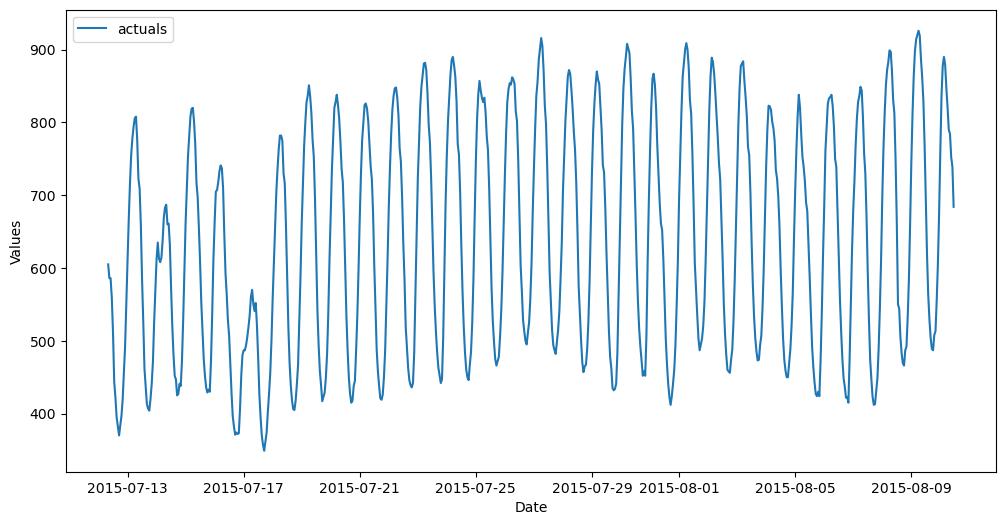

In [4]:
f.plot()
plt.show()

### ACF/PACF at Series Level

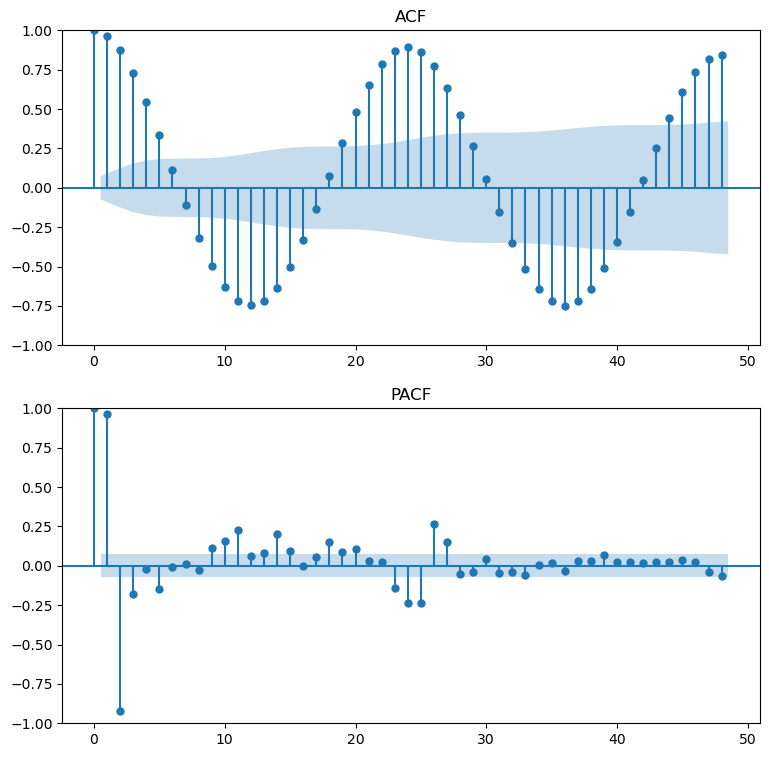

In [5]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=48)
f.plot_pacf(ax=axs[1],title='PACF',lags=48,method='ywm')
plt.show()

### Augmented Dickey-Fuller Test

In [6]:
critical_pval = 0.05
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

Augmented Dickey-Fuller results:
the test-stat value is: -2.06
the p-value is 0.2623
the series is not stationary
----------------------------------------------------------------------------------------------------


### ACF/PACF at Series First Difference

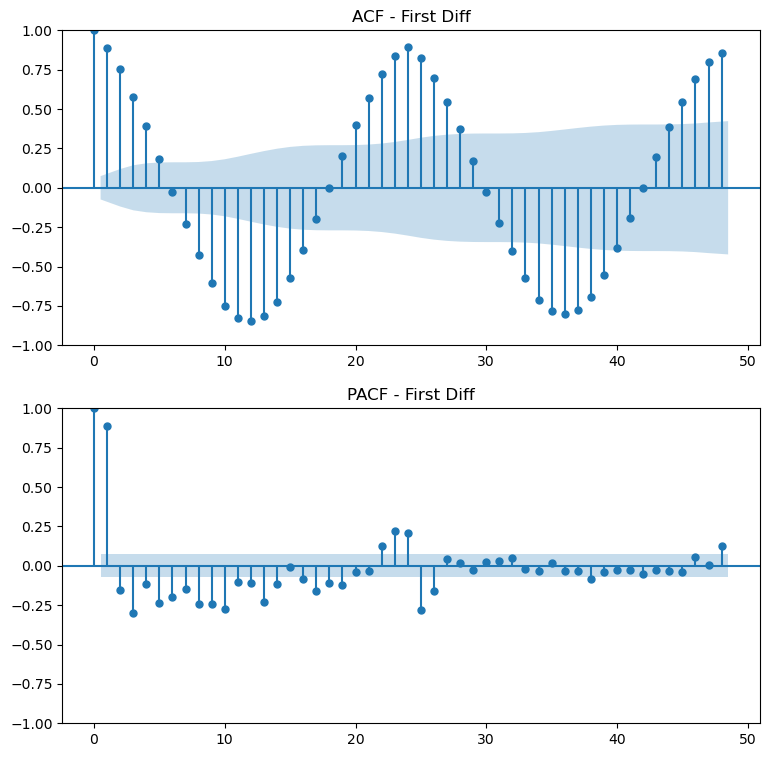

In [7]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF - First Diff',lags=48,diffy=1)
f.plot_pacf(ax=axs[1],title='PACF - First Diff',lags=48,diffy=1,method='ywm')
plt.show()

### Seasonal Decomp

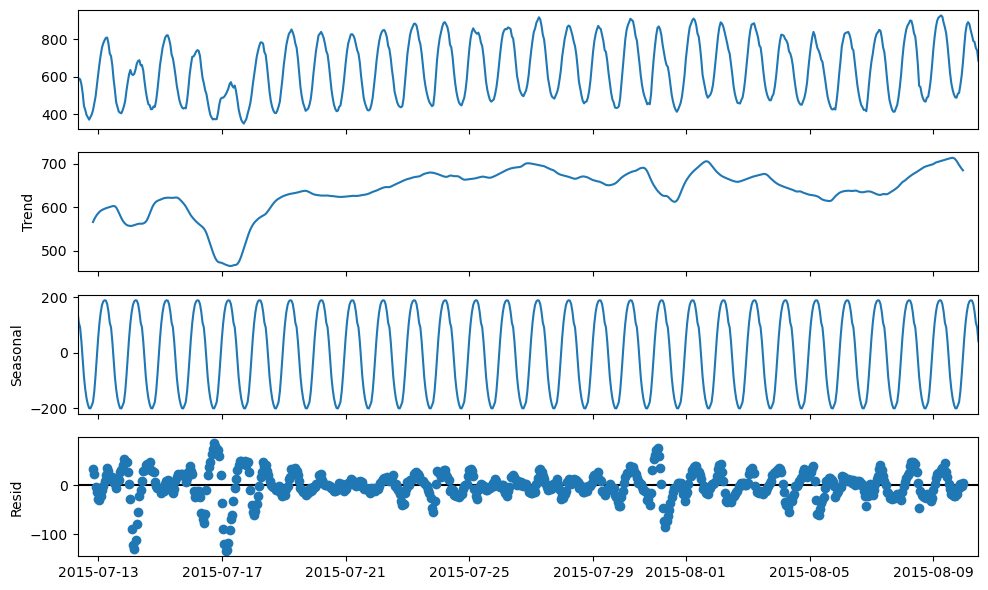

In [8]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

## Naive
- This will serve as a benchmark model
- It will propagate the last 24 observations in a "seasonal naive" model

In [9]:
f.set_estimator('naive')
f.manual_forecast(seasonal=True)

## ARIMA

### Manual ARIMA: (5,1,4) x (1,1,1,24)

In [10]:
f.set_estimator('arima')
f.manual_forecast(
    order = (5,1,4),
    seasonal_order = (1,1,1,24),
    call_me = 'manual_arima',
)

## RNN

### Tanh Activation

Epoch 1/15
14/14 [==============================] - 11s 240ms/step - loss: 0.3440 - val_loss: 0.2448
Epoch 2/15
14/14 [==============================] - 1s 98ms/step - loss: 0.2534 - val_loss: 0.2353
Epoch 3/15
14/14 [==============================] - 1s 94ms/step - loss: 0.2454 - val_loss: 0.2223
Epoch 4/15
14/14 [==============================] - 1s 91ms/step - loss: 0.2116 - val_loss: 0.1467
Epoch 5/15
14/14 [==============================] - 1s 90ms/step - loss: 0.1270 - val_loss: 0.0770
Epoch 6/15
14/14 [==============================] - 1s 90ms/step - loss: 0.0922 - val_loss: 0.0608
Epoch 7/15
14/14 [==============================] - 1s 91ms/step - loss: 0.0818 - val_loss: 0.0612
Epoch 8/15
14/14 [==============================] - 1s 89ms/step - loss: 0.0784 - val_loss: 0.0539
Epoch 9/15
14/14 [==============================] - 1s 90ms/step - loss: 0.0747 - val_loss: 0.0585
Epoch 10/15
14/14 [==============================] - 1s 90ms/step - loss: 0.0747 - val_loss: 0.0776
Epoch 1

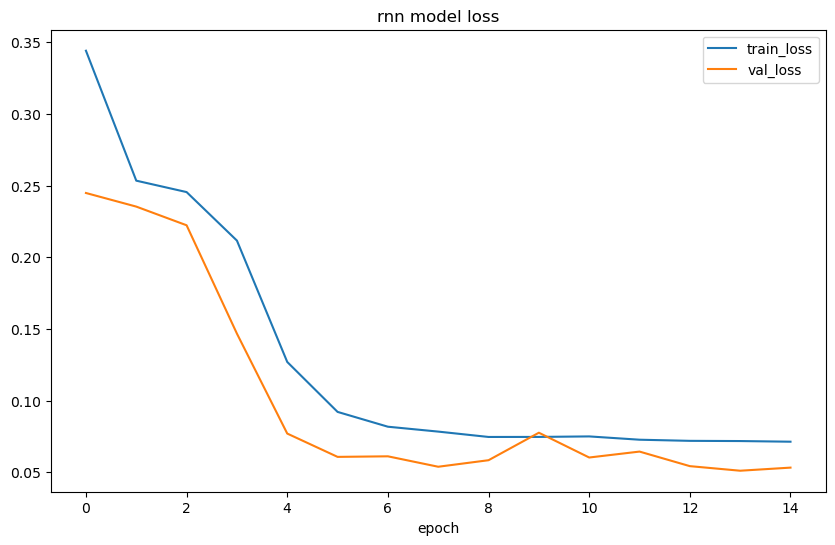

Epoch 1/15
16/16 [==============================] - 12s 210ms/step - loss: 0.3303 - val_loss: 0.2509
Epoch 2/15
16/16 [==============================] - 1s 93ms/step - loss: 0.2445 - val_loss: 0.2418
Epoch 3/15
16/16 [==============================] - 1s 93ms/step - loss: 0.2266 - val_loss: 0.1829
Epoch 4/15
16/16 [==============================] - 1s 89ms/step - loss: 0.1349 - val_loss: 0.0801
Epoch 5/15
16/16 [==============================] - 1s 94ms/step - loss: 0.0924 - val_loss: 0.0877
Epoch 6/15
16/16 [==============================] - 2s 98ms/step - loss: 0.0812 - val_loss: 0.0636
Epoch 7/15
16/16 [==============================] - 1s 94ms/step - loss: 0.0764 - val_loss: 0.0592
Epoch 8/15
16/16 [==============================] - 1s 89ms/step - loss: 0.0758 - val_loss: 0.0636
Epoch 9/15
16/16 [==============================] - 2s 99ms/step - loss: 0.0719 - val_loss: 0.0808
Epoch 10/15
16/16 [==============================] - 1s 87ms/step - loss: 0.0821 - val_loss: 0.0575
Epoch 1

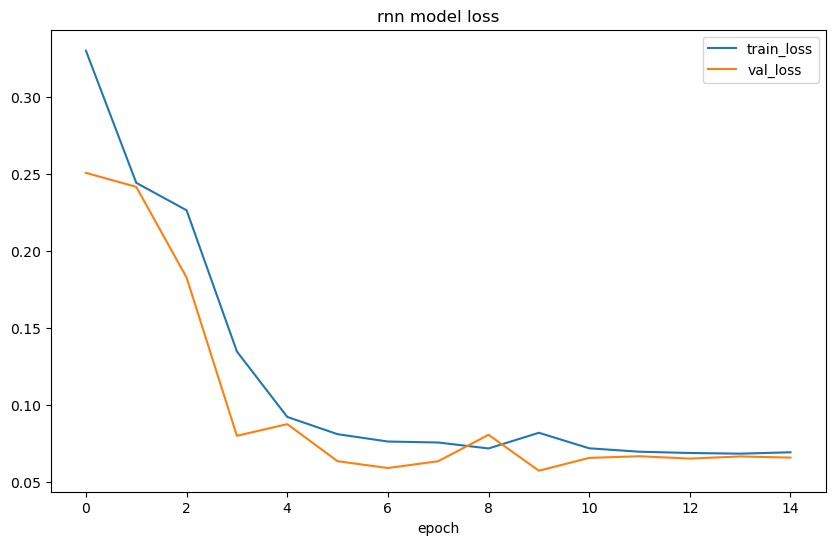

In [11]:
f.set_estimator('rnn')
f.manual_forecast(
    lags = 48,
    layers_struct=[
        ('LSTM',{'units':100,'activation':'tanh'}),
        ('LSTM',{'units':100,'activation':'tanh'}),
        ('LSTM',{'units':100,'activation':'tanh'}),
    ],
    optimizer = 'Adam',
    epochs = 15,
    plot_loss = True,
    validation_split=0.2,
    call_me = 'rnn_tanh_activation',
)

### Relu Activation

Epoch 1/15
14/14 [==============================] - 7s 136ms/step - loss: 0.4472 - val_loss: 0.3233
Epoch 2/15
14/14 [==============================] - 1s 90ms/step - loss: 0.2935 - val_loss: 0.2480
Epoch 3/15
14/14 [==============================] - 1s 91ms/step - loss: 0.2531 - val_loss: 0.2398
Epoch 4/15
14/14 [==============================] - 1s 88ms/step - loss: 0.2506 - val_loss: 0.2353
Epoch 5/15
14/14 [==============================] - 1s 93ms/step - loss: 0.2487 - val_loss: 0.2339
Epoch 6/15
14/14 [==============================] - 1s 94ms/step - loss: 0.2472 - val_loss: 0.2348
Epoch 7/15
14/14 [==============================] - 1s 94ms/step - loss: 0.2458 - val_loss: 0.2309
Epoch 8/15
14/14 [==============================] - 1s 96ms/step - loss: 0.2403 - val_loss: 0.2203
Epoch 9/15
14/14 [==============================] - 1s 93ms/step - loss: 0.2433 - val_loss: 0.2331
Epoch 10/15
14/14 [==============================] - 1s 106ms/step - loss: 0.2234 - val_loss: 0.1908
Epoch 1

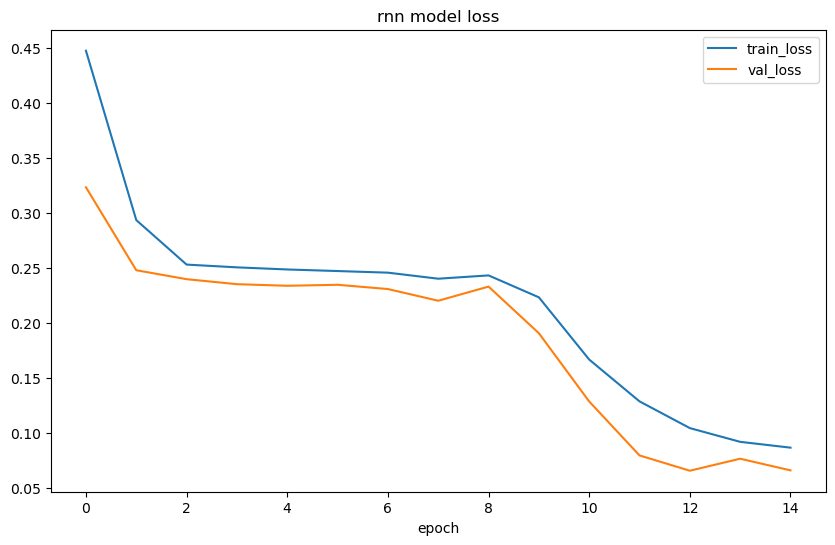

Epoch 1/15
16/16 [==============================] - 7s 135ms/step - loss: 0.4250 - val_loss: 0.3007
Epoch 2/15
16/16 [==============================] - 1s 94ms/step - loss: 0.2688 - val_loss: 0.2524
Epoch 3/15
16/16 [==============================] - 2s 95ms/step - loss: 0.2453 - val_loss: 0.2457
Epoch 4/15
16/16 [==============================] - 1s 94ms/step - loss: 0.2404 - val_loss: 0.2445
Epoch 5/15
16/16 [==============================] - 2s 96ms/step - loss: 0.2378 - val_loss: 0.2403
Epoch 6/15
16/16 [==============================] - 2s 97ms/step - loss: 0.2306 - val_loss: 0.2319
Epoch 7/15
16/16 [==============================] - 2s 97ms/step - loss: 0.2033 - val_loss: 0.1860
Epoch 8/15
16/16 [==============================] - 2s 102ms/step - loss: 0.1710 - val_loss: 0.1540
Epoch 9/15
16/16 [==============================] - 2s 99ms/step - loss: 0.1379 - val_loss: 0.0931
Epoch 10/15
16/16 [==============================] - 2s 96ms/step - loss: 0.1035 - val_loss: 0.0822
Epoch 1

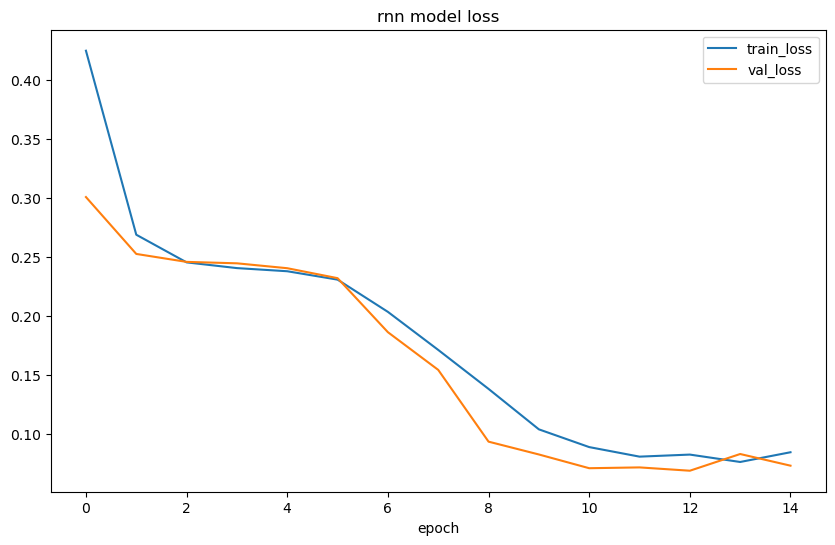

In [12]:
f.manual_forecast(
    lags = 48,
    layers_struct=[
        ('LSTM',{'units':100,'activation':'relu'}),
        ('LSTM',{'units':100,'activation':'relu'}),
        ('LSTM',{'units':100,'activation':'relu'}),
    ],
    optimizer = 'Adam',
    epochs = 15,
    plot_loss = True,
    validation_split=0.2,
    call_me = 'rnn_relu_activation',
)

## Prophet

In [13]:
f.set_estimator('prophet')
f.manual_forecast()

22:07:17 - cmdstanpy - INFO - Chain [1] start processing
22:07:19 - cmdstanpy - INFO - Chain [1] done processing
22:07:19 - cmdstanpy - INFO - Chain [1] start processing
22:07:20 - cmdstanpy - INFO - Chain [1] done processing


## Compare Results

In [14]:
results = f.export(determine_best_by='TestSetSMAPE')
ms = results['model_summaries']
ms[
    [
        'ModelNickname',
        'TestSetLength',
        'TestSetSMAPE',
        'InSampleSMAPE',
    ]
]

,ModelNickname,TestSetLength,TestSetSMAPE,InSampleSMAPE
0,prophet,48,0.040069,0.038252
1,manual_arima,48,0.047060,0.017995
2,rnn_relu_activation,48,0.067114,0.080657
3,rnn_tanh_activation,48,0.067999,0.062481
4,naive,48,0.093079,0.067697


Using the last 48 observations in the `Forecaster` object to test each model, the arima model performed the best.

## Plot Results

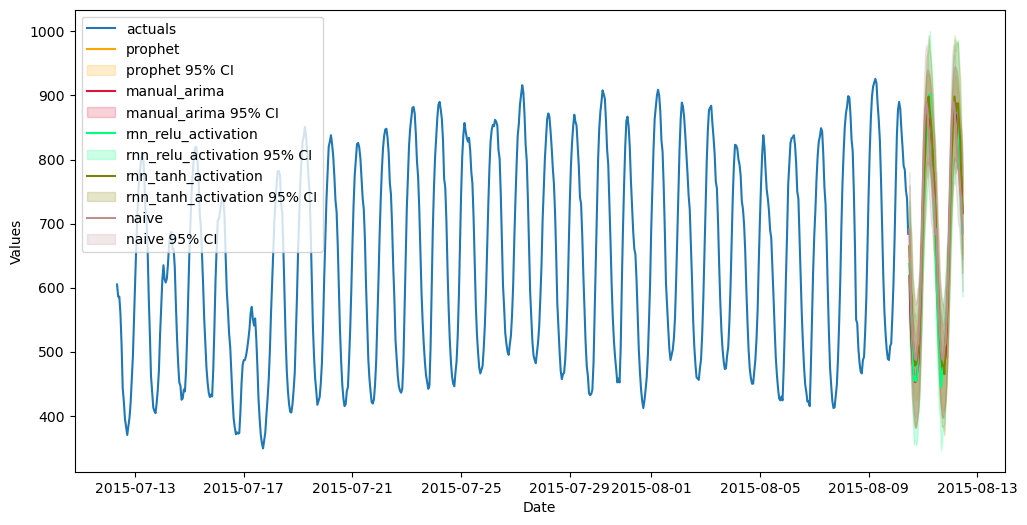

In [15]:
f.plot(order_by="TestSetSMAPE",ci=True)
plt.show()

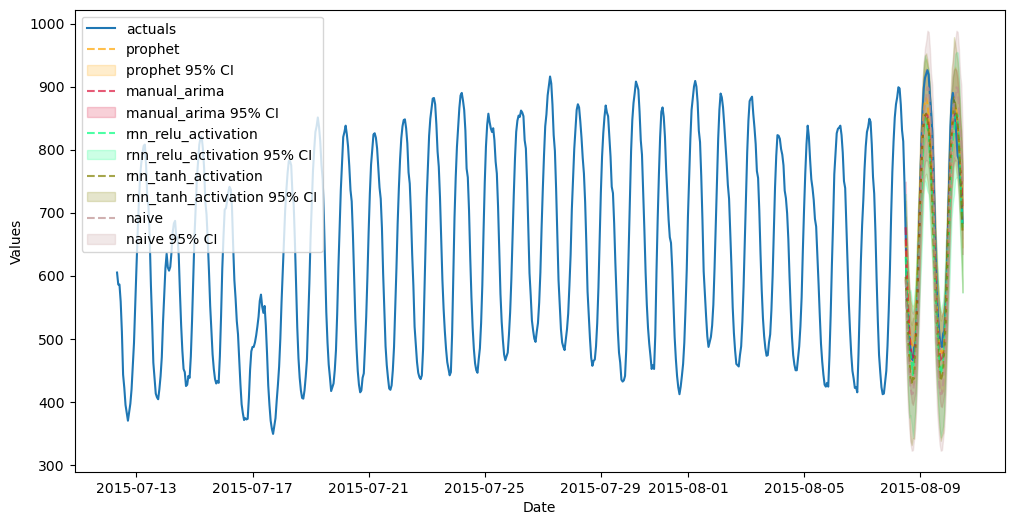

In [16]:
f.plot_test_set(order_by="TestSetSMAPE",ci=True)
plt.show()

## Stack Models

- To stack models in scalecast, you can either use the [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) from scikit-learn, or you can add the predictions from already-evaluated models into the `Forecaster` object using `Forecaster.add_signals()`. The latter approach is more advantageous as it can do everything that can be done with the StackingRegressor, but it can use non scikit-learn model classes, can more flexibly use other regressors, and is easier to tune.  
- In the below example, we are using the signals generated from two LSTM models, an ARIMA model, a naive model, and Meta Prophet. We will also add the last 48 series lags to the object.  
- One key point in the function below: we are specifying the `train_only` argument as False. This means that our test set will be compromised as we will introduce leakage from the other models. I chose to leave it False because this approach will ultimately be tested with a separate out-of-sample test set. The rule of thumb around this is to make this argument True if you want to report accurate test-set metrics but leave False when you want to deliver a Forecast into a future horizon. You can run this function twice with each option specified if you want to do both--run first time with `train_only=True`, evaluate models, and check the test-set metrics. Then, rerun with `train_only=False` and re-evaluate models to deliver future point predictions.  

In [17]:
f.add_ar_terms(48)
f.add_signals(
    f.history.keys(),
    #train_only = True, # uncomment to avoid leakage into the test set
)
f.set_estimator('catboost')
f

Forecaster(
    DateStartActuals=2015-07-12T08:00:00.000000000
    DateEndActuals=2015-08-10T11:00:00.000000000
    Freq=H
    N_actuals=700
    ForecastLength=48
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'signal_naive', 'signal_manual_arima', 'signal_rnn_tanh_activation', 'signal_rnn_relu_activation', 'signal_prophet']
    TestLength=48
    ValidationMetric=smape
    ForecastsEvaluated=['naive', 'manual_arima', 'rnn_tanh_activation', 'rnn_relu_activation', 'prophet']
    CILevel=0.95
    CurrentEstimator=catboost
    GridsFile=Grids
)

Now we can train three catboost models:
- One with all added regressors (the model signals and lags)  
- One with just the model signals  
- One with just the series lags  

In [18]:
f.manual_forecast(
    Xvars='all',
    call_me='catboost_all_reg',
    verbose = False,
)
f.save_feature_importance(method = 'shap') # it would be interesting to see the shapley scores (later)
f.manual_forecast(
    Xvars=[x for x in f.get_regressor_names() if x.startswith('AR')], 
    call_me = 'catboost_lags_only',
    verbose = False,
)
f.manual_forecast(
    Xvars=[x for x in f.get_regressor_names() if not x.startswith('AR')], 
    call_me = 'catboost_signals_only',
    verbose = False,
)

C:\ProgramData\Anaconda3\lib\site-packages\scalecast\Forecaster.py:2705: Warning: Cannot set shap feature importance on catboost_all_reg. Here is the error: No module named 'shap'
  warnings.warn(


In [19]:
results = f.export(determine_best_by='TestSetSMAPE')
ms = results['model_summaries']
ms[
    [
        'ModelNickname',
        'TestSetLength',
        'TestSetSMAPE',
        'InSampleSMAPE',
    ]
]

,ModelNickname,TestSetLength,TestSetSMAPE,InSampleSMAPE
0,catboost_signals_only,48,0.017085,0.006989
1,catboost_all_reg,48,0.021992,0.003149
2,prophet,48,0.040069,0.038252
3,manual_arima,48,0.047060,0.017995
4,catboost_lags_only,48,0.060460,0.003447
5,rnn_relu_activation,48,0.067114,0.080657
6,rnn_tanh_activation,48,0.067999,0.062481
7,naive,48,0.093079,0.067697


Unsuprisingly, now our catboost model with just the signals is showing the best test-set scores. But the test set has been compromised for all models that used signals as inputs. A way around that would have been to call `add_signals(train_only=True)`. Another way to really know how these models performed out-of-sample, we need to compare it with a separate out-of-sample test set.

## Check Performance of Forecast on Held-Out Sample

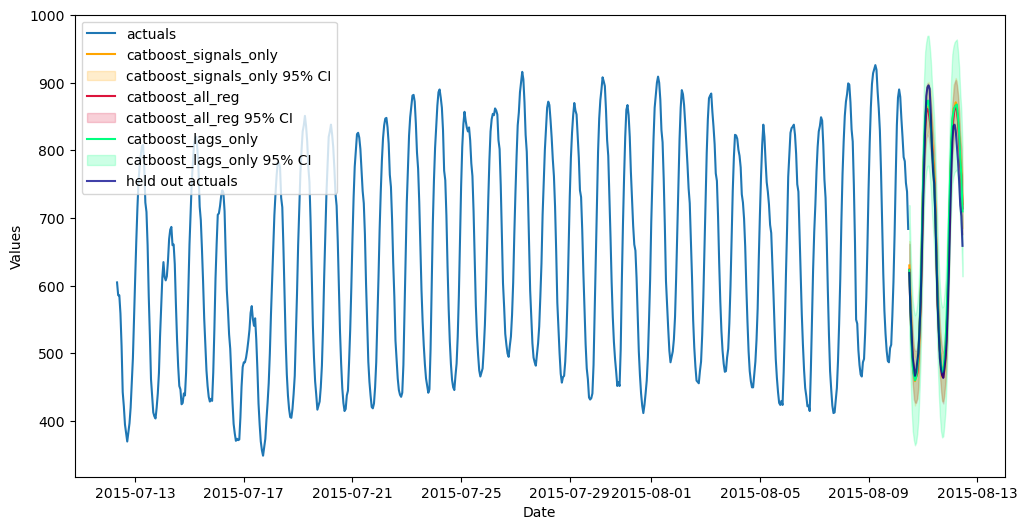

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(
    models = [m for m in f.history if m.startswith('catboost')],
    order_by="TestSetSMAPE",
    ci=True,
    ax = ax
)
sns.lineplot(
    x = f.future_dates, 
    y = test_set, 
    ax = ax,
    label = 'held out actuals',
    color = 'darkblue',
    alpha = .75,
)
plt.show()

In [21]:
test_results = pd.DataFrame(index = f.history.keys(),columns = ['smape','mase'])
for k, v in f.history.items():
    test_results.loc[k,['smape','mase']] = [
        metrics.smape(test_set,v['Forecast']),
        metrics.mase(test_set,v['Forecast'],m=24,obs=f.y),
    ]
    
test_results.sort_values('smape')

,smape,mase
catboost_all_reg,0.027421,0.467428
catboost_signals_only,0.030522,0.517262
prophet,0.032176,0.526252
manual_arima,0.032896,0.541697
catboost_lags_only,0.035468,0.58522
rnn_relu_activation,0.036796,0.588711
rnn_tanh_activation,0.044489,0.719329
naive,0.052629,0.827014


Now, we finally get to the crux of the analysis, where we can see that the catboost that used both the other model signals and the series lags performed best, followed by the catboost model that used only signals. This demonstrates the power of stacking and how it can make good models great.

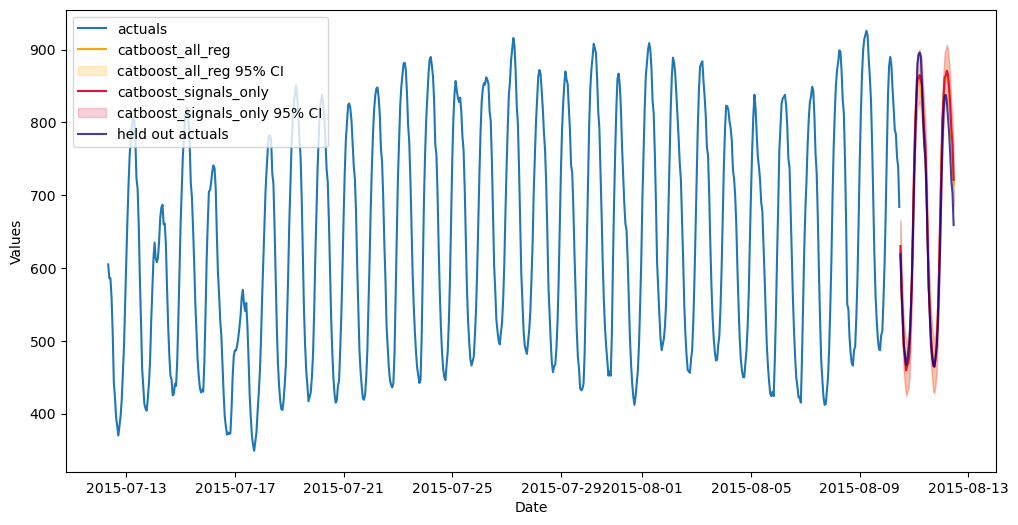

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(
    models = ['catboost_all_reg','catboost_signals_only'],
    ci=True,
    ax = ax
)
sns.lineplot(
    x = f.future_dates, 
    y = test_set, 
    ax = ax,
    label = 'held out actuals',
    color = 'darkblue',
    alpha = .75,
)
plt.show()

## View each covariate's shapley score
- Looking at the scores below, it is not surprising that the ARIMA signal was deemed the most important covariate in the final catboost model.

In [24]:
f.export_feature_importance('catboost_all_reg')

KeyError: 'feature_importance'